In [ ]:
# !pip install pandas # instalar o pandas
# !pip install geopandas # instalar o geopandas para trabalhar com dados geograficos
# !pip install matplotlib

In [4]:
import requests
import pandas as pd
import geopandas as gpd
from pyspark.sql import SparkSession

In [19]:
## Constantes

ibge_url_municipios_sp = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2024/UFs/SP/SP_Municipios_2024.zip'
nasa_api_base_url = 'https://power.larc.nasa.gov/api/temporal/climatology'
jars = ['./aws-java-sdk-bundle-1.12.262.jar', './hadoop-aws-3.3.4.jar']

In [6]:
# Passo 1: baixar os dados do ibge sobre os municipios brasileiros (municipios de SP)
# Camada silver

In [16]:
municipios_sp_gdf = gpd.read_file(ibge_url_municipios_sp)
municipios_sp_gdf['localizacao'] = municipios_sp_gdf.geometry.centroid
municipios_sp_gdf['lat'] = municipios_sp_gdf.localizacao.y
municipios_sp_gdf['long'] = municipios_sp_gdf.localizacao.x
municipios_sp_gdf.head(2)

/tmp/ipykernel_1293/2332861259.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipios_sp_gdf['localizacao'] = municipios_sp_gdf.geometry.centroid


,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,localizacao,lat,long
0,3513009,Cotia,350001,São Paulo,3501,São Paulo,35,São Paulo,SP,3,Sudeste,SE,3550308,São Paulo/SP,323.994,"POLYGON ((-46.91759 -23.65551, -46.91764 -23.6...",POINT (-46.96051 -23.67515),-23.675154,-46.960512
1,3532827,Nova Campina,350004,Itapeva,3502,Sorocaba,35,São Paulo,SP,3,Sudeste,SE,None,None,385.375,"POLYGON ((-48.89989 -24.10036, -48.87064 -24.1...",POINT (-48.97291 -24.19062),-24.190622,-48.972913


<Axes: >

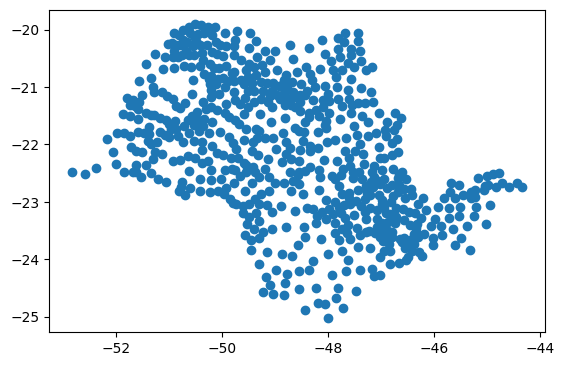

In [13]:
municipios_sp_gdf['localizacao'].plot()

In [18]:
targets = ['CD_MUN', 'NM_MUN', 'SIGLA_UF', 'lat', 'long']
municipios_sp_gdf = municipios_sp_gdf[targets]
municipios_sp_gdf.head(2)

,CD_MUN,NM_MUN,SIGLA_UF,lat,long
0,3513009,Cotia,SP,-23.675154,-46.960512
1,3532827,Nova Campina,SP,-24.190622,-48.972913


In [20]:
## Sessao spark

spark = (
    SparkSession
        .builder
        .master("spark://spark:7077")
        .appName('MinIO - Teste')
        .config('spark.hadoop.fs.s3a.endpoint', 'http://minio:9000')
        .config('spark.hadoop.fs.s3a.access.key', 'minioadmin')
        .config('spark.hadoop.fs.s3a.secret.key', 'minioadmin')
        .config('spark.hadoop.fs.s3a.path.style.access', 'true')
        .config('spark.hadoop.fs.s3a.connection.ssl.enabled', 'false')
        .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
        .config('spark.jars', ', '.join(jars))
        .getOrCreate()
)

25/05/07 00:59:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [21]:
df = spark.createDataFrame(municipios_sp_gdf)
df.show()

+-------+---------------+--------+-------------------+-------------------+
| CD_MUN|         NM_MUN|SIGLA_UF|                lat|               long|
+-------+---------------+--------+-------------------+-------------------+
|3513009|          Cotia|      SP| -23.67515440059829|-46.960512331155044|
|3532827|   Nova Campina|      SP| -24.19062212735448|  -48.9729133502219|
|3502507|      Aparecida|      SP|-22.914206040127134| -45.23721921739436|
|3543303| Ribeirão Pires|      SP|-23.701078895008695| -46.40280398464695|
|3542008|       Quintana|      SP| -22.10019502617809| -50.36927535342769|
|3545100|      Salmourão|      SP|-21.588038862741328| -50.87629611896304|
|3532801|   Nova Aliança|      SP|  -21.0626207545152| -49.51597569054507|
|3535903|      Paranapuã|      SP| -20.06377095677244| -50.59404469415986|
|3522802|     Itaporanga|      SP| -23.67294942202673| -49.45849135508454|
|3525904|        Jundiaí|      SP|-23.194602028794943|-46.913011931724306|
|3534609|   Osvaldo Cruz|

In [23]:
df.coalesce(1).write.mode('overwrite').parquet('s3a://bronze/municipios_sp.parquet')

In [ ]:
# Passo 2: Dados climaticos por municipios
# Camada Silver
# /api/temporal/climatology/point

In [ ]:
# Passo 3: Agregar os dados
# Camada Gold